In [1]:
%matplotlib widget
# Jonah Wiecek (jwiecek 1966868)
# Laila Albalkhi (lalbalkh 1968154)

In [2]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold

# setup plotting 
from IPython import get_ipython         
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

# Load the data

In [3]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [4]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [5]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

5


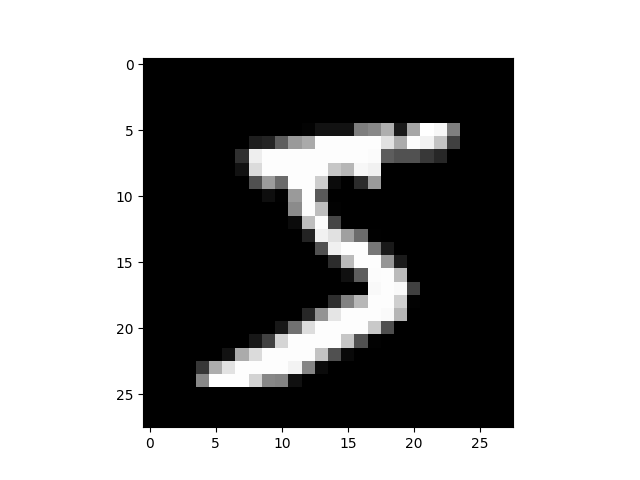

In [6]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [7]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

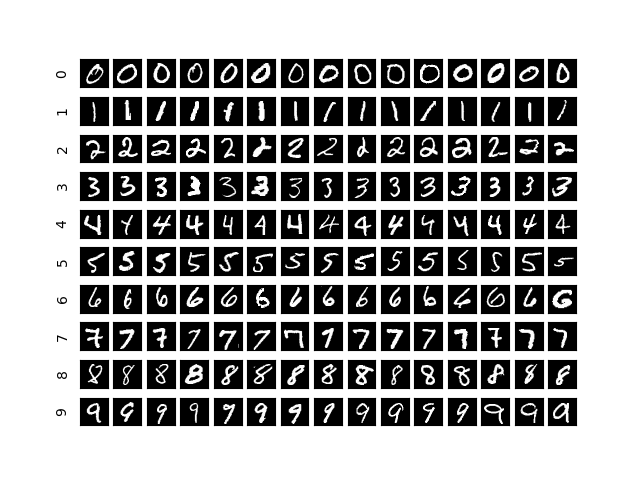

In [8]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

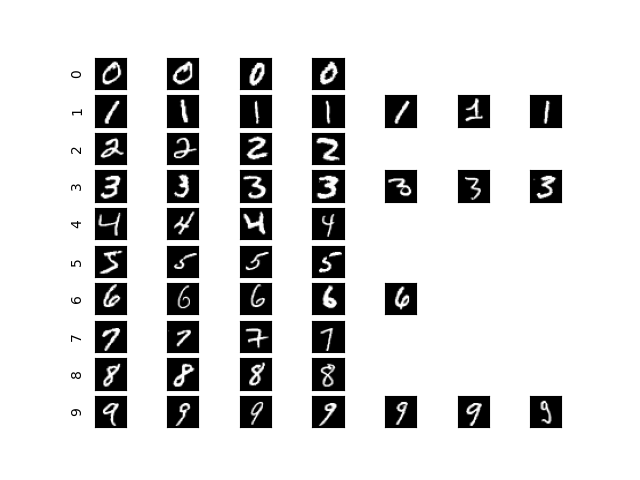

In [9]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [10]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [11]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = (np.bincount(y,minlength=C) + (alpha-1)) / (N + (C)*(alpha-1))
    

    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K))
    for c in range(C):
        for j in range(D):
                cls[c,j,:] = (np.bincount(X[y==c,j],minlength=K) + (alpha-1)) / (np.sum(y == c) + (K)*(alpha-1))

    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [12]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [13]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [14]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [15]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    for c in range(C):
        for j in range(D):
            logjoint[:,c] += logcls[c,j,Xnew[:,j]]
    logjoint += logpriors

    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")
    yhat = np.argmax(logjoint, axis=1)
    logprob = logjoint[np.arange(Nnew), yhat]

    #Normalize logprob
    logprob = logprob - logsumexp(logjoint.T)
    
    return dict(yhat=yhat, logprob=logprob)

In [16]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0], dtype=int64),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

# 3 Experiments on MNIST Digits Data

In [17]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [18]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

Text(0.5, 0.98, 'Digits grouped by predicted label')

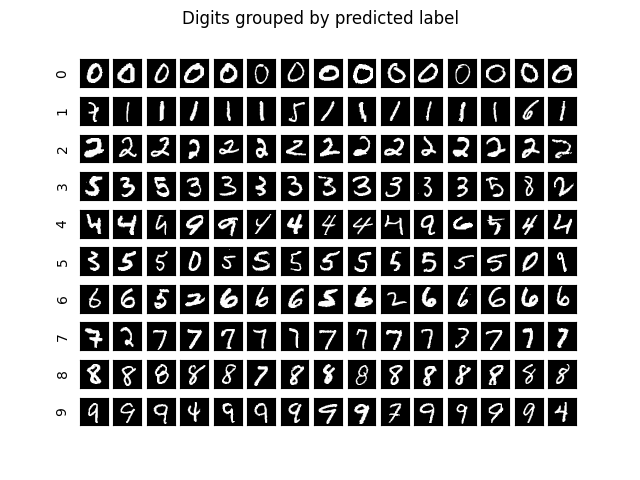

In [19]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

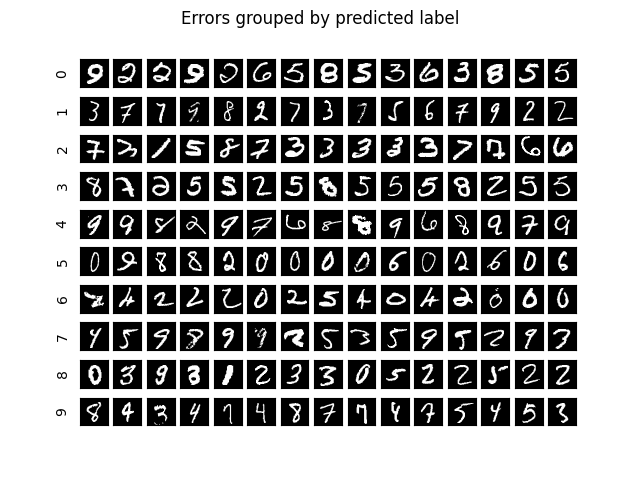

In [20]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

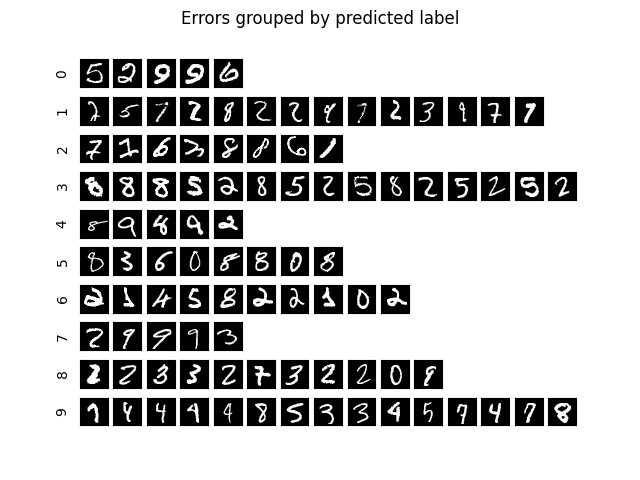

In [21]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [22]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


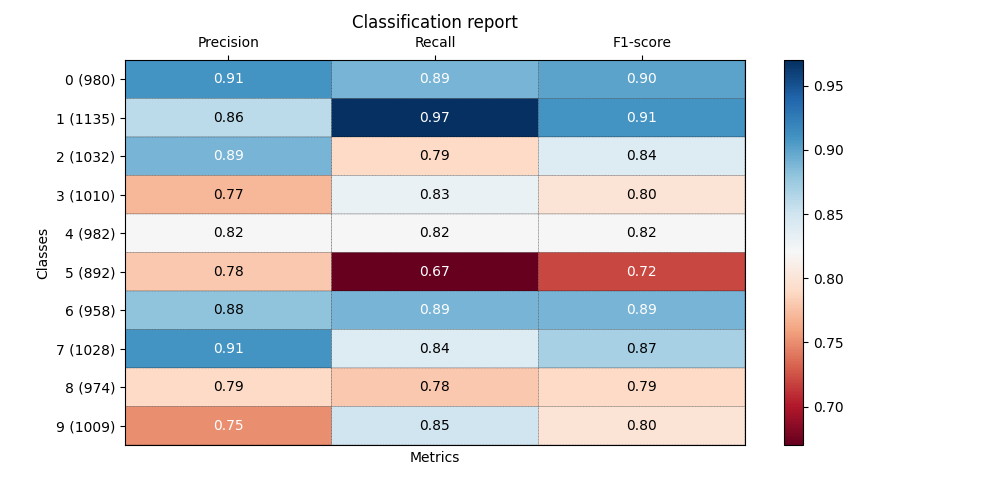

In [23]:
# plot the classification report as a heatmap

# referenced from https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report 
# to visualize the classification report

def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)  

    plt.xlim( (0, AUC.shape[1]) )

    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    plt.colorbar(c)
    show_values(c)

    ax.invert_yaxis()
    ax.xaxis.tick_top()  

    fig = plt.gcf()
    fig.set_size_inches((figure_width, figure_height))


def plot_classification_report(classification_report):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    classnames = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1 : len(t) - 1]]
        support.append(int(t[-1]))
        classnames.append(t[0])
        plotMat.append(v)

    print(classes)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classnames[idx], sup) for idx, sup  in enumerate(support)]

    figure_width = 10
    figure_height = 5
    correct_orientation = False
    
    heatmap(np.array(plotMat), "Classification report", xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap='RdBu')

plot_classification_report(sklearn.metrics.classification_report(ytest, yhat))

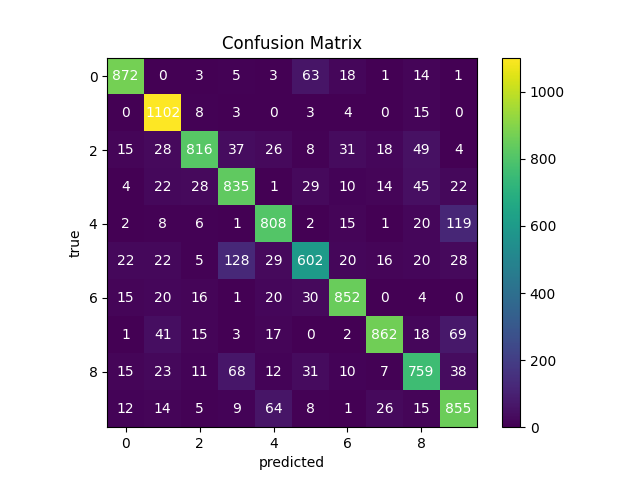

In [24]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.title("Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937704
0.9859050917808865
0.8812574072791101


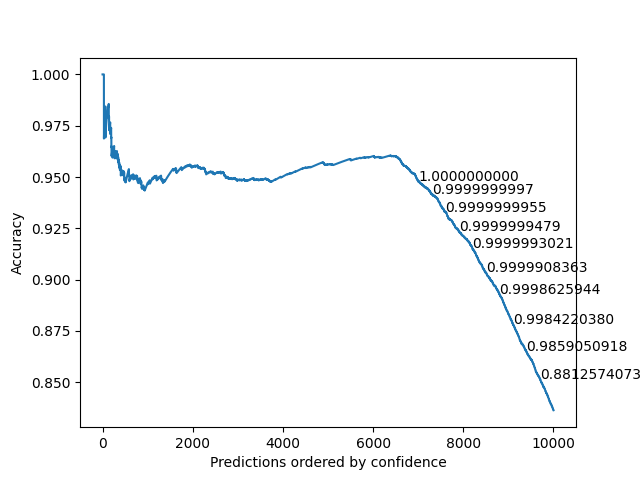

In [25]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

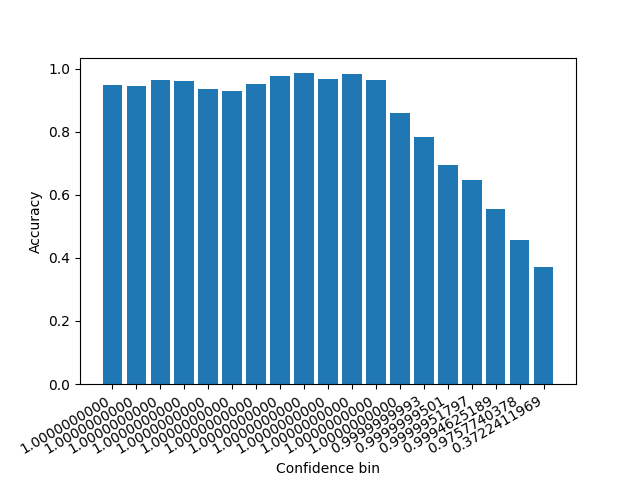

In [26]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 20) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)

plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [27]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
def K_foldValidation(K,alphas,X,y,memo= {}, nb_train = nb_train, nb_predict = nb_predict):
    Kf = KFold(n_splits=K, shuffle=True, random_state=23)  
    accuracies = np.zeros(len(alphas))
    for i,alpha in enumerate(alphas) :
        if alpha in memo:
            accuracies[i] = memo[alpha]
            continue
        for i_train, i_test in Kf.split(X , y):
            model = nb_train(X[i_train, :], y[i_train], alpha=alpha)
            pred = nb_predict(model, X[i_test, :])
            yhat = pred["yhat"]
            acc = sklearn.metrics.accuracy_score(y[i_test], yhat)
            accuracies[i]+= acc/K
        memo[alpha] = accuracies[i]  
    return accuracies

In [28]:
def plot_iterative_process(plot_points,memo,optimalalpha):
    nextplot()
    for i, points in enumerate(plot_points):
        plt.scatter(points,[memo[point]for point in points],label = 'Iteration '+str(i+1))
    plt.scatter(optimalalpha, memo[optimalalpha],marker="x",label = 'Max Accuracy', color = 'black')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Alpha')
    plt.legend()

    plt.show()    

In [29]:
K=5
start=0.5
end=3
stopping_criteria = 0.0005
stepsize=(end-start)/5
iteration=1
memo={}
plot_points=[]
while True:
    alphas = np.arange(start,end,stepsize)
    plot_points.append(alphas)
    accuracies = K_foldValidation(K,alphas,X,y,memo)
    max_index = np.argmax(accuracies)
    optimalalpha = alphas[max_index]
    print("Iteration: ",iteration, "start: ",start, "end: ",end, "stepsize: ",stepsize)
    print("Alpha with the highest accuracy is: ",optimalalpha, "with the accuracy: ",accuracies[max_index])
    if optimalalpha ==start and accuracies[max_index]-accuracies[max_index+1] < stopping_criteria:
        break
    elif optimalalpha == end and accuracies[max_index]-accuracies[max_index-1] < stopping_criteria:
        break
    elif accuracies[max_index]-accuracies[max_index-1] < stopping_criteria and accuracies[max_index]-accuracies[max_index+1] < stopping_criteria:
        break
    else:
        iteration+=1
        start=alphas[max_index-1]
        end=alphas[max_index+1]
        stepsize/=2
        end+=stepsize/2 #this is to include "end" in the next iteration since np.arange excludes the end-point


C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_35392\1191416724.py:52: RuntimeWarning: divide by zero encountered in l

Iteration:  1 start:  0.5 end:  3 stepsize:  0.5
Alpha with the highest accuracy is:  1.5 with the accuracy:  0.8320500000000001
Iteration:  2 start:  1.0 end:  2.125 stepsize:  0.25
Alpha with the highest accuracy is:  1.25 with the accuracy:  0.8347
Iteration:  3 start:  1.0 end:  1.5625 stepsize:  0.125
Alpha with the highest accuracy is:  1.125 with the accuracy:  0.8352833333333334
Iteration:  4 start:  1.0 end:  1.28125 stepsize:  0.0625
Alpha with the highest accuracy is:  1.125 with the accuracy:  0.8352833333333334


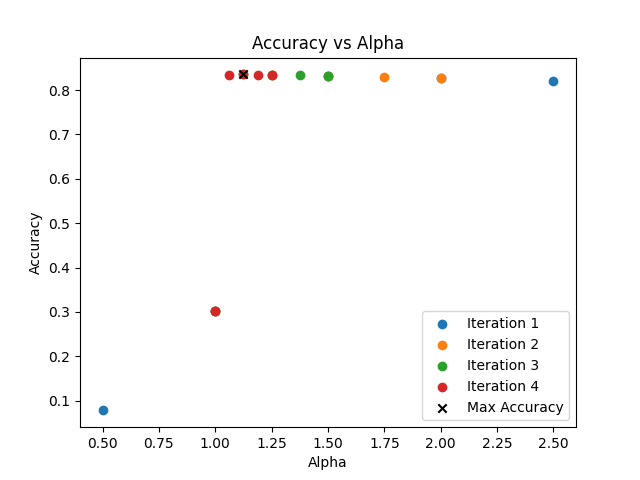

In [30]:
plot_iterative_process(plot_points,memo,optimalalpha)

In [31]:
model_nb3 = nb_train(X, y, alpha=optimalalpha)
pred_nb3 = nb_predict(model_nb3, Xtest)
yhat = pred_nb3["yhat"]
print("Accuracy with alpha found from cross validation: ",sklearn.metrics.accuracy_score(ytest, yhat))

Accuracy:  0.8363


# 5 Generating Data

In [32]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        theta = np.exp(logcls[c,:,:])
        for j in range(D):
            Xgen[i,j] = np.random.choice(range(K),p=theta[j,:])

    return Xgen

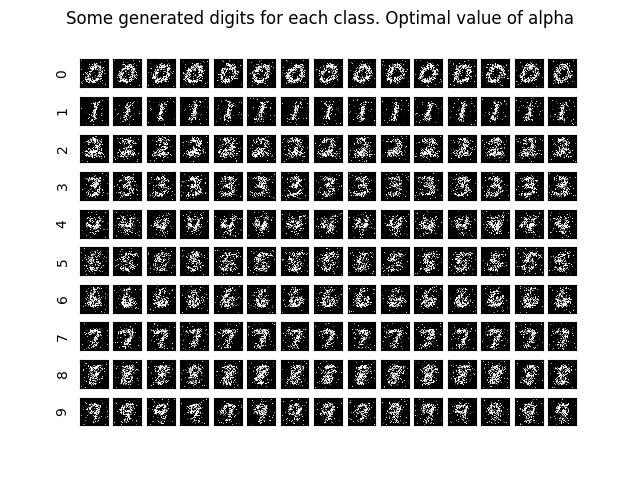

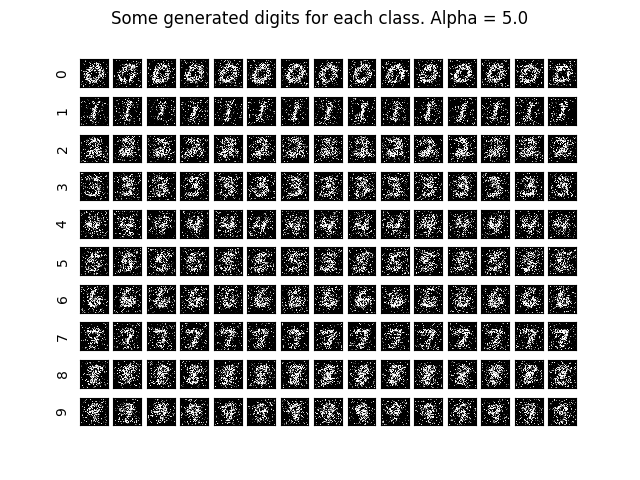

In [33]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
testalpha =5.0
model_nb5 = nb_train(X, y, alpha=testalpha)
for i, model in enumerate([model_nb3, model_nb5]):
    Xgen = nb_generate(model, ygen)
    nextplot()
    showdigits(Xgen, ygen)
    plt.suptitle("Some generated digits for each class. "+("Optimal value of alpha" if i==0 else "Alpha = "+str(testalpha)))

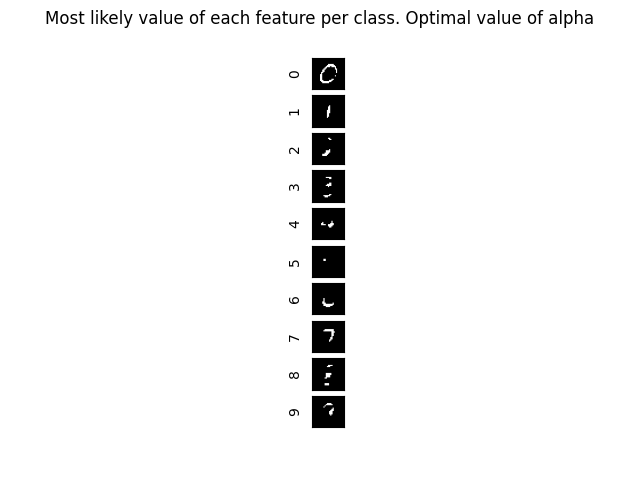

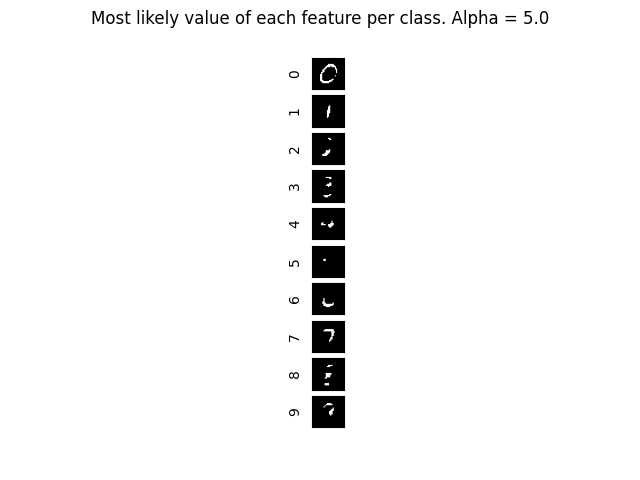

In [34]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for i,model in enumerate([model_nb3, model_nb5]):
    for c in range(10):
        Xmax[c,] = np.apply_along_axis(np.argmax, 1, model["logcls"][c, :, :])
    nextplot()
    showdigits(Xmax, ymax)
    plt.suptitle("Most likely value of each feature per class. "+("Optimal value of alpha" if i==0 else "Alpha = "+str(testalpha)))

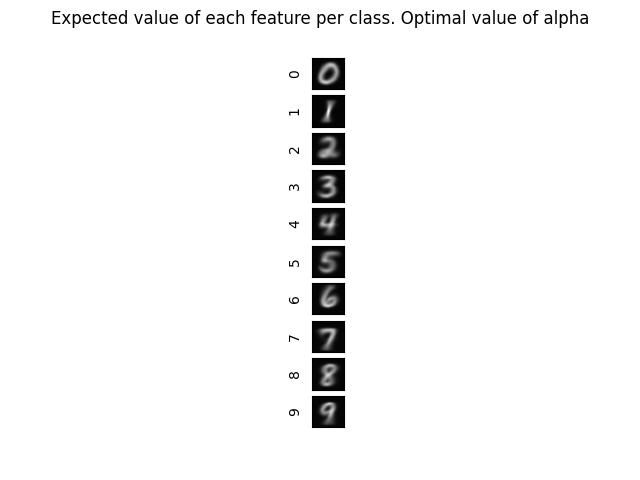

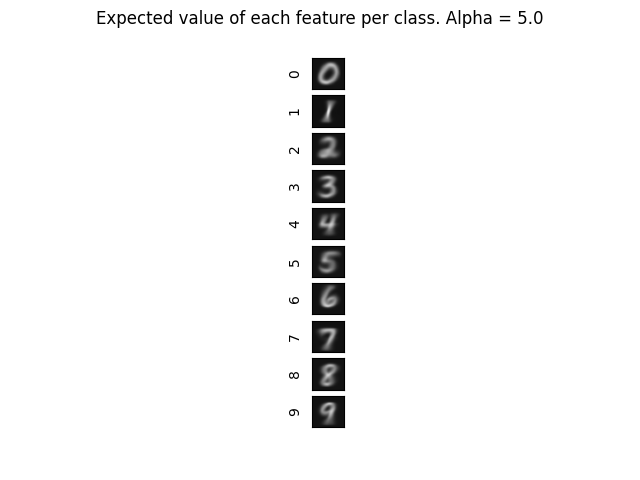

In [35]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for i,model in enumerate([model_nb3, model_nb5]):
    for c in range(10):
        Xmean[c,] = np.apply_along_axis(
            np.sum, 1, np.exp(model["logcls"][c, :, :]) * np.arange(256)
        )

    nextplot()
    showdigits(Xmean, ymean)
    plt.suptitle("Expected value of each feature per class. "+("Optimal value of alpha" if i==0 else "Alpha = "+str(testalpha)))